# Teste PAMAP2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Definição de bibliotecas a serem utilizadas

In [ ]:
!pip install tsfresh
!pip install autogluon.tabular
!pip install pycatch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.1/312.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from tsfresh.utilities.distribution import MultiprocessingDistributor
from tsfresh.feature_extraction import MinimalFCParameters
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from autogluon.tabular import TabularPredictor
from sklearn.metrics import confusion_matrix
from tsfresh import extract_features
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pycatch22
import warnings
import logging

## Prepare data

In [ ]:
class InitializeAllData():
  def __init__(self, root=''):
    self.root = root
    self.columns = None
    self.initial_data = None
    self.data_cleaning = None
    self.data_preprocessing = None
    self.data_segments = None
    self.data_segments_resampled = None
    self.start_time = None
    self.break_points_segments = []
    self.segments = None
    self.shape_segments = None
    self.segments_durations = None
    self.classes = None
    self.dict_segments = None

    self.create_cols()
    self.loadData()

    if self.initial_data is not None:
      self.clear_data()
      self.define_timestamp()
      self.verify_regularity()
      self.prepare_segments()
      self.create_segments()
      self.verify_shape_segments()
      self.verify_segments_duration()
      self.define_classes()
      self.define_dict_segments()
      self.show_dict_segments()

  def get_root(self):
    return self.root

  def get_data_cleaning(self):
    return self.data_cleaning

  def get_data_preprocessing(self):
    return self.data_preprocessing

  def get_data_segments(self):
    return self.data_segments

  def get_segments(self):
    return self.segments

  def get_shape_segments(self):
    return self.shape_segments

  def get_segments_durations(self):
    return self.segments_durations

  def get_classes(self):
    return self.classes

  def get_segments(self):
    return self.segments

  def get_dict_segments(self):
    return self.dict_segments

  def create_cols(self):
    activityIDdict = {0: 'transient', 1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking', 5: 'running', 6: 'cycling', 7: 'Nordic_walking', 9: 'watching_TV', 10: 'computer_work', 11: 'car driving', 12: 'ascending_stairs', 13: 'descending_stairs', 16: 'vacuum_cleaning', 17: 'ironing', 18: 'folding_laundry', 19: 'house_cleaning', 20: 'playing_soccer', 24: 'rope_jumping' }
    colNames = ["timestamp", "activityID","heartrate"]
    IMUhand = ['handTemperature', 'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 'handGyro1', 'handGyro2', 'handGyro3', 'handMagne1', 'handMagne2', 'handMagne3','handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']
    IMUchest = ['chestTemperature', 'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 'chestGyro1', 'chestGyro2', 'chestGyro3', 'chestMagne1', 'chestMagne2', 'chestMagne3', 'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']
    IMUankle = ['ankleTemperature', 'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'ankleMagne1', 'ankleMagne2', 'ankleMagne3','ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']
    self.columns = colNames + IMUhand + IMUchest + IMUankle

  def loadData(self):
    self.initial_data = pd.read_table(self.root, header=None, sep="\s+", names=self.columns)
    print("Data loaded.")

  def clear_data(self):
    self.data_cleaning = self.initial_data.copy()
    self.data_cleaning = self.data_cleaning.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4', 'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4', 'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'], axis = 1)  # removal of orientation columns as they are not needed
    self.data_cleaning = self.data_cleaning.drop(self.data_cleaning[self.data_cleaning.activityID == 0].index) #removal of any row of activity 0 as it is transient activity which it is not used
    self.data_cleaning = self.data_cleaning.interpolate() #removal of any remaining NaN value cells by constructing new data points in known set of data points

    self.data_cleaning['heartrate'] = self.data_cleaning['heartrate'].fillna(self.data_cleaning['heartrate'].median())
    self.data_cleaning.reset_index(drop=True, inplace=True)
    print("Data cleaned.")

  def define_timestamp(self):
    self.data_preprocessing = self.data_cleaning.copy()
    self.data_preprocessing['timestamp'] = pd.to_datetime(self.data_preprocessing['timestamp'], unit='s')
    self.data_preprocessing['timestamp'].apply(lambda x: self.data_preprocessing['timestamp'].mode() if x == pd.NaT else x)

    print("Timestamp is defined.")

  def verify_regularity(self):
    self.data_segments = self.data_preprocessing.copy()
    time_diffs = self.data_segments['timestamp'].diff().dropna()
    self.data_segments = self.data_segments.set_index('timestamp')

    if len(time_diffs.unique()) > 1:
      print('Data is a irregular time series.')
      self.data_segments_resampled = self.data_segments.resample('10ms').mean().ffill()

      new_time_diffs = self.data_segments_resampled.index.to_series().diff().dropna()

      if len(new_time_diffs.unique()) == 1 and new_time_diffs.iloc[0] == timedelta(milliseconds=10):
        print('Data are already resampled, so now is regular.')

  def verify_end_segment(self, row):
    interval = row['timestamp'] - self.start_time

    if interval > timedelta(seconds=10):
      self.break_points_segments.append(row['index']-1)
      self.start_time = row['timestamp']

  def prepare_segments(self):
    self.data_segments_resampled['timestamp'] = pd.to_datetime(self.data_segments_resampled.index, unit='s')
    self.data_segments_resampled['index'] = range(len(self.data_segments_resampled))

    self.start_time = self.data_segments_resampled.iloc[0]['timestamp']

    self.data_segments_resampled.apply(self.verify_end_segment, axis=1)
    self.data_segments_resampled.set_index('index', inplace=True)

  def create_segments(self):
    print("Creating segments.")

    self.segments = []
    self.segment = pd.DataFrame()

    start_segment = self.data_segments_resampled.index[0]

    for break_point_segment in self.break_points_segments:
      segment = self.data_segments_resampled.loc[start_segment:break_point_segment]
      segment.reset_index(drop=True, inplace=True)
      self.segments.append(segment)
      start_segment = break_point_segment + 1

    print(f"Number of segments created: {len(self.segments)}")

  def verify_shape_segments(self):
    self.shape_segments = pd.Series()

    for idx, segment in enumerate(self.segments):
      if len(self.segments[idx]['activityID'].unique()) > 1:
        self.segments.pop(idx)
      else:
        self.shape_segments.loc[len(self.shape_segments)] = segment.shape[0]

    print(f"Segments shape: {self.shape_segments.unique()}")

  def verify_segments_duration(self):
    self.segments_durations = pd.Series()

    for idx, _ in enumerate(self.segments):
      last_row = self.segments[idx]['timestamp'].shape[0]
      duration = self.segments[idx]['timestamp'][last_row-1] - self.segments[idx]['timestamp'][0]
      self.segments_durations.loc[len(self.segments_durations)] = duration

    print(f"Segments duration is:\n {self.segments_durations.unique()}")

  def define_classes(self):
    self.classes = self.data_cleaning['activityID'].unique()
    self.classes.sort()

    print(f"Classes: {self.classes}")

  def define_dict_segments(self):
    self.dict_segments = {key:[] for key in self.get_classes()}

    for segment in self.segments:
      self.dict_segments[segment['activityID'].unique()[0]].append(segment)

  def show_dict_segments(self):
    for key in self.dict_segments:
      print(f'Class {key}: {len(self.dict_segments[key])} segments')

In [ ]:
def extract_tsfresh(segments, group):
  data_extracted = pd.DataFrame()

  for segment in segments:
    activity = segment.iloc[0]['activityID']
    segment_extracted = pd.DataFrame()

    warnings.filterwarnings('ignore')
    logging.getLogger('tsfresh').setLevel(logging.ERROR)

    segment_extracted = extract_features(timeseries_container=segment, column_id='activityID', column_sort='timestamp', default_fc_parameters=MinimalFCParameters(), disable_progressbar=True)
    segment_extracted['activityID'] = activity
    segment_extracted['group'] = group
    data_extracted = pd.concat([data_extracted, segment_extracted])

  data_extracted.reset_index(drop=True, inplace=True)
  print("Data segments extracted with TSFresh.")

  return data_extracted

In [ ]:
def input_nans(row, data):
  for col_name in data.columns:
    if pd.isna(row[col_name]):
      id_act = row['activityID']
      row[col_name] = data[data['activityID'] == id_act][col_name].mean()

  return row

In [ ]:
  def extract_catch22(segments, group):
    data_extracted = pd.DataFrame()

    for segment in segments:
      activity = segment.iloc[0]['activityID']
      segment_extracted = pd.DataFrame()

      for col in segment.columns:
        cols_extracted = pd.DataFrame()

        if col != 'timestamp' and col != 'activityID':
          features = pycatch22.catch22_all(segment[col].values, short_names=True)

          num_cols = len(features["names"])
          names = features["names"]
          values = features["values"]

          cols_extracted = pd.DataFrame({col+name: values[i::num_cols] for i, name in enumerate(names)})

        segment_extracted = pd.concat([segment_extracted, cols_extracted], axis=1)

      segment_extracted['activityID'] = activity
      segment_extracted['group'] = group
      data_extracted = pd.concat([data_extracted, segment_extracted])

    data_extracted = data_extracted.apply(input_nans, axis=1, data=data_extracted)
    data_extracted.reset_index(drop=True, inplace=True)

    print("Data segments extracted with Catch22.")

    return data_extracted

In [ ]:
list_of_files = ['/content/drive/MyDrive/Profissional/Faculdade/TCC/pamap2+physical+activity+monitoring/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject101.dat',
                 '/content/drive/MyDrive/Profissional/Faculdade/TCC/pamap2+physical+activity+monitoring/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject102.dat',
                 '/content/drive/MyDrive/Profissional/Faculdade/TCC/pamap2+physical+activity+monitoring/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject103.dat',
                 '/content/drive/MyDrive/Profissional/Faculdade/TCC/pamap2+physical+activity+monitoring/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject104.dat',
                 '/content/drive/MyDrive/Profissional/Faculdade/TCC/pamap2+physical+activity+monitoring/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject105.dat',
                 '/content/drive/MyDrive/Profissional/Faculdade/TCC/pamap2+physical+activity+monitoring/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject106.dat',
                 '/content/drive/MyDrive/Profissional/Faculdade/TCC/pamap2+physical+activity+monitoring/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject107.dat',
                 '/content/drive/MyDrive/Profissional/Faculdade/TCC/pamap2+physical+activity+monitoring/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject108.dat']

In [ ]:
def make_data(list_of_files):
  subjects = []

  for id, subject in enumerate(list_of_files):
    print(f'\nSUBJECT {id+1}')
    data_subject = InitializeAllData(subject)
    subjects.append(data_subject)

  return subjects

In [ ]:
def make_extracted_data(subjects, extraction_mode):
  train_data = pd.DataFrame()
  test_data = pd.DataFrame()

  for id, subject in enumerate(subjects):
    segments_estracted = pd.DataFrame()
    print(f'\nSUBJECT {id+1}')

    if extraction_mode == 'tsfresh':
      segments_estracted = extract_tsfresh(segments=subject.get_segments(), group=int(subject.get_root().split('.')[0].split('subject1')[1]))
    elif extraction_mode == 'catch22':
      segments_estracted = extract_catch22(segments=subject.get_segments(), group=int(subject.get_root().split('.')[0].split('subject1')[1]))

    if subject.get_root() is not list_of_files[6]:
      train_data = pd.concat([train_data, segments_estracted])
    else:
      test_data = pd.concat([test_data, segments_estracted])

  return train_data, test_data

In [ ]:
subjects = make_data(list_of_files)


SUBJECT 1
Data loaded.
Data cleaned.
Timestamp is defined.
Data is a irregular time series.
Data are already resampled, so now is regular.
Creating segments.
Number of segments created: 358
Segments shape: [1001]
Segments duration is:
 <TimedeltaArray>
['0 days 00:00:10']
Length: 1, dtype: timedelta64[ns]
Classes: [ 1  2  3  4  5  6  7 12 13 16 17 24]
Class 1: 27 segments
Class 2: 22 segments
Class 3: 30 segments
Class 4: 28 segments
Class 5: 35 segments
Class 6: 29 segments
Class 7: 29 segments
Class 12: 25 segments
Class 13: 40 segments
Class 16: 35 segments
Class 17: 33 segments
Class 24: 12 segments

SUBJECT 2
Data loaded.
Data cleaned.
Timestamp is defined.
Data is a irregular time series.
Data are already resampled, so now is regular.
Creating segments.
Number of segments created: 418
Segments shape: [1001]
Segments duration is:
 <TimedeltaArray>
['0 days 00:00:10']
Length: 1, dtype: timedelta64[ns]
Classes: [ 1  2  3  4  5  6  7 12 13 16 17 24]
Class 1: 29 segments
Class 2: 24 

In [ ]:
train_tsfresh, test_tsfresh = make_extracted_data(subjects, 'tsfresh')


SUBJECT 1
Data segments extracted with TSFresh.

SUBJECT 2
Data segments extracted with TSFresh.

SUBJECT 3
Data segments extracted with TSFresh.

SUBJECT 4
Data segments extracted with TSFresh.

SUBJECT 5
Data segments extracted with TSFresh.

SUBJECT 6
Data segments extracted with TSFresh.

SUBJECT 7
Data segments extracted with TSFresh.

SUBJECT 8
Data segments extracted with TSFresh.


In [ ]:
test_tsfresh

,heartrate__sum_values,heartrate__median,heartrate__mean,heartrate__length,heartrate__standard_deviation,heartrate__variance,heartrate__root_mean_square,heartrate__maximum,heartrate__absolute_maximum,heartrate__minimum,...,ankleMagne3__mean,ankleMagne3__length,ankleMagne3__standard_deviation,ankleMagne3__variance,ankleMagne3__root_mean_square,ankleMagne3__maximum,ankleMagne3__absolute_maximum,ankleMagne3__minimum,activityID,group
0,75851.00,75.00,75.775225,1001.0,2.666040,7.107767,75.822111,96.00,96.00,73.00,...,-3.685789,1001.0,3.809585e+00,1.451294e+01,5.300753,8.23359,12.14040,-12.14040,1.0,7
1,83360.00,85.00,83.276723,1001.0,4.313711,18.608103,83.388373,88.00,88.00,74.00,...,-7.693029,1001.0,4.709430e-01,2.217873e-01,7.707430,-6.46861,9.58840,-9.58840,1.0,7
2,83139.00,84.00,83.055944,1001.0,3.793837,14.393201,83.142547,88.00,88.00,77.00,...,-7.506165,1001.0,4.032910e-01,1.626436e-01,7.516991,-6.32906,8.88094,-8.88094,1.0,7
3,75609.00,75.00,75.533467,1001.0,0.719010,0.516976,75.536889,77.00,77.00,75.00,...,-7.465030,1001.0,3.994440e-01,1.595555e-01,7.475709,-6.33091,8.74170,-8.74170,1.0,7
4,70617.00,71.00,70.546454,1001.0,2.280529,5.200813,70.583305,75.00,75.00,66.00,...,-7.433445,1001.0,3.564584e-01,1.270626e-01,7.441987,-6.32817,9.02351,-9.02351,1.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,103353.25,103.25,103.250000,1001.0,0.000000,0.000000,103.250000,103.25,103.25,103.25,...,1.360500,1001.0,4.440892e-16,1.972152e-31,1.360500,1.36050,1.36050,1.36050,6.0,7
289,103353.25,103.25,103.250000,1001.0,0.000000,0.000000,103.250000,103.25,103.25,103.25,...,1.360500,1001.0,4.440892e-16,1.972152e-31,1.360500,1.36050,1.36050,1.36050,6.0,7
290,83401.00,82.00,83.317682,1001.0,4.944689,24.449946,83.464281,112.00,112.00,81.00,...,11.735171,1001.0,1.035501e+01,1.072263e+02,15.650577,42.71540,42.71540,-7.63848,5.0,7
291,117062.00,116.00,116.945055,1001.0,3.578838,12.808079,116.999803,124.00,124.00,112.00,...,29.395781,1001.0,7.836485e+00,6.141050e+01,30.422401,42.03000,42.03000,8.36422,5.0,7


In [ ]:
train_catch22, test_catch22 = make_extracted_data(subjects, 'catch22')


SUBJECT 1
Data segments extracted with Catch22.

SUBJECT 2
Data segments extracted with Catch22.

SUBJECT 3
Data segments extracted with Catch22.

SUBJECT 4
Data segments extracted with Catch22.

SUBJECT 5
Data segments extracted with Catch22.

SUBJECT 6
Data segments extracted with Catch22.

SUBJECT 7
Data segments extracted with Catch22.

SUBJECT 8
Data segments extracted with Catch22.


In [ ]:
test_catch22

,heartrateDN_HistogramMode_5,heartrateDN_HistogramMode_10,heartrateCO_f1ecac,heartrateCO_FirstMin_ac,heartrateCO_HistogramAMI_even_2_5,heartrateCO_trev_1_num,heartrateMD_hrv_classic_pnn40,heartrateSB_BinaryStats_mean_longstretch1,heartrateSB_TransitionMatrix_3ac_sumdiagcov,heartratePD_PeriodicityWang_th0_01,...,ankleMagne3DN_OutlierInclude_n_001_mdrmd,ankleMagne3SP_Summaries_welch_rect_area_5_1,ankleMagne3SB_BinaryStats_diff_longstretch0,ankleMagne3SB_MotifThree_quantile_hh,ankleMagne3SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,ankleMagne3SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,ankleMagne3SP_Summaries_welch_rect_centroid,ankleMagne3FC_LocalSimple_mean3_stderr,activityID,group
0,-0.178162,-0.609298,174.254865,666.0,0.563872,-0.215831,0.001000,423.000000,0.166667,165.0,...,0.728272,9.908862e-01,8.0,1.688151,0.354167,0.520833,0.012272,0.131313,1.0,7.0
1,0.770014,0.932206,208.200595,655.0,1.404753,0.000005,0.055000,529.000000,0.166667,174.0,...,-0.740260,3.954688e-01,6.0,2.184900,0.729167,0.645833,1.067651,1.000523,1.0,7.0
2,1.012731,1.157630,224.964784,657.0,1.516016,-0.000003,0.022000,524.000000,0.166667,0.0,...,-0.161838,2.394130e-01,6.0,2.195439,0.145833,0.687500,1.527845,1.140597,1.0,7.0
3,-0.463554,-0.602564,174.812898,603.0,0.946228,-0.000044,0.022000,398.000000,0.166667,262.0,...,-0.062937,2.144480e-01,6.0,2.194306,0.625000,0.354167,1.632156,1.128596,1.0,7.0
4,0.768537,0.176865,212.450978,644.0,1.486060,-0.000009,0.033000,534.000000,0.166667,175.0,...,-0.030969,2.125364e-01,5.0,2.180635,0.145833,0.854167,1.448078,1.144597,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,-0.019710,0.190170,0.000000,0.0,1.094623,-1.376992,0.030391,522.391304,0.157085,0.0,...,0.000000,3.392938e-28,1.0,0.000000,0.125000,0.854167,0.000000,0.000000,6.0,7.0
289,-0.019710,0.190170,0.000000,0.0,1.094623,-1.376992,0.030391,522.391304,0.157085,0.0,...,0.000000,3.392938e-28,1.0,0.000000,0.125000,0.854167,0.000000,0.000000,6.0,7.0
290,0.158135,-0.155176,22.133383,512.0,0.153895,0.001201,0.011000,200.000000,0.040000,0.0,...,0.205794,9.934329e-01,21.0,1.577722,0.416667,0.291667,0.036816,0.150949,5.0,7.0
291,-1.045922,-1.213490,210.937687,682.0,1.483315,0.000004,0.022000,487.000000,0.166667,174.0,...,-0.083916,9.951219e-01,15.0,1.400740,0.500000,0.375000,0.085903,0.230366,5.0,7.0


## AutoGluon Classification





In [ ]:
def detailed_results(leaderboard, predictor, data, train_models: bool=True):
  classes = list(data['activityID'].unique())
  detailed_results = {}

  if train_models:
    for model in leaderboard['model'].tolist():
      X_train = data.drop(['activityID'], axis=1)
      y_train = data['activityID']

      y_train_pred = predictor.predict(X_train, model=model)

      detailed_results[model] = {'Model': predictor._trainer.load_model(model),
                                'Train Report': classification_report(y_train, y_train_pred, zero_division=0),
                                'Train Report Latex': pd.DataFrame(classification_report(y_train, y_train_pred, zero_division=0, output_dict=True)).to_latex(),
                                'Confusion Matrix Train': confusion_matrix(y_train, y_train_pred, labels=classes)}
  else:
    for model in leaderboard['model'].tolist():
      X_test = data.drop(['activityID'], axis=1)
      y_test = data['activityID']

      y_test_pred = predictor.predict(X_test, model=model)

      detailed_results[model] = {'Model': predictor._trainer.load_model(model),
                                'Test Report': classification_report(y_test, y_test_pred, zero_division=0),
                                'Test Report Latex': pd.DataFrame(classification_report(y_test, y_test_pred, zero_division=0, output_dict=True)).to_latex(),
                                'Confusion Matrix Test': confusion_matrix(y_test, y_test_pred, labels=classes)}

  return detailed_results

In [ ]:
def autogluon_classification(train_data, test_data):
  predictor = TabularPredictor(label="activityID", eval_metric='f1_weighted', problem_type='multiclass', groups='group')
  predictor.fit(train_data=train_data, presets='best_quality', hyperparameter_tune_kwargs='auto', num_bag_folds=len(train_data['group'].unique()), num_bag_sets=1, fit_weighted_ensemble=True)
  leaderboard_train = predictor.leaderboard().sort_values(by='score_val', ascending=False).head(5)
  predictor.refit_full(set_best_to_refit_full=True)
  leaderboard_test = predictor.leaderboard(data=test_data, refit_full=True).sort_values(by='score_test', ascending=False).head(5)

  # Coletar os resultados da vaidação cruzada usando a técnica LOGO
  detailed_results_train = detailed_results(leaderboard_train, predictor, train_data)
  # Coletar os resultados de teste das predições dos modelos retreinados com todo o dado
  detailed_results_test = detailed_results(leaderboard_test, predictor, test_data, train_models=False)

  return leaderboard_train, leaderboard_test, detailed_results_train, detailed_results_test

In [ ]:
leaderboard_train_tsfresh, leaderboard_test_tsfresh, detailed_results_train_tsfresh, detailed_results_test_tsfresh = autogluon_classification(train_tsfresh, test_tsfresh)

A saída de streaming foi truncada nas últimas 5000 linhas.
    return self._hyperparameter_tune(hpo_executor=hpo_executor, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/ensemble/stacker_ensemble_model.py", line 184, in _hyperparameter_tune
    return super()._hyperparameter_tune(X=X, y=y, k_fold=k_fold, hpo_executor=hpo_executor, preprocess_kwargs=preprocess_kwargs, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/ensemble/bagged_ensemble_model.py", line 1335, in _hyperparameter_tune
    return skip_hpo(X=X, y=y, X_val=X_val, y_val=y_val, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/abstract/model_trial.py", line 122, in skip_hpo
    fit_and_save_model(model=model, fit_args=fit_model_args, predict_proba_args=predict_proba_args, y_val=y_val, time_start=time.time(), time_limit=time_limit)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/abstract/model_trial.py", line 9

In [ ]:
leaderboard_train_tsfresh

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.850806,f1_weighted,2.679403,118.732552,0.005094,2.773669,2,True,58
1,WeightedEnsemble_L3,0.846313,f1_weighted,11.033884,808.076270,0.003893,1.853677,3,True,63
2,ExtraTreesGini_BAG_L2,0.810967,f1_weighted,11.029991,806.222593,0.586493,14.008870,2,True,59
3,ExtraTreesEntr_BAG_L2,0.800810,f1_weighted,10.996640,806.216399,0.553141,14.002676,2,True,60
4,ExtraTreesGini_BAG_L1,0.799957,f1_weighted,0.783478,11.973019,0.783478,11.973019,1,True,6


In [ ]:
leaderboard_test_tsfresh

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_r42_BAG_L1_FULL,0.855132,None,f1_weighted,0.011258,None,2.365966,0.011258,None,2.365966,1,True,55
1,NeuralNetTorch_BAG_L1/T2_FULL,0.835088,None,f1_weighted,0.026165,None,1.464541,0.026165,None,1.464541,1,True,8
2,NeuralNetFastAI_r143_BAG_L1_FULL,0.823422,None,f1_weighted,0.021232,None,2.861334,0.021232,None,2.861334,1,True,25
3,ExtraTreesEntr_BAG_L2_FULL,0.822308,None,f1_weighted,1.645228,None,99.596984,0.105939,None,2.204645,2,True,60
4,NeuralNetFastAI_BAG_L1/T1_FULL,0.821609,None,f1_weighted,0.025305,None,1.172307,0.025305,None,1.172307,1,True,3


In [ ]:
leaderboard_train_catch22, leaderboard_test_catch22, detailed_results_train_catch22, detailed_results_test_catch22 = autogluon_classification(train_catch22, test_catch22)

A saída de streaming foi truncada nas últimas 5000 linhas.
ModuleNotFoundError: No module named 'catboost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/abstract/model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/abstract/model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/abstract/abstract_model.py", line 856, in fit
    out = self._fit(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/ensemble/stacker_ensemble_model.py", line 165, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/ensemble/bagged_ensemble_model.py", line 288, in _fit

In [ ]:
leaderboard_train_catch22

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.836773,f1_weighted,4.942749,148.945056,0.005541,0.899508,3,True,16
1,WeightedEnsemble_L2,0.827220,f1_weighted,2.857430,93.018021,0.005334,0.613768,2,True,9
2,ExtraTreesEntr_BAG_L2,0.824693,f1_weighted,4.252359,113.143884,0.639836,17.320711,2,True,12
3,ExtraTrees_r49_BAG_L2,0.824396,f1_weighted,4.229370,112.639396,0.616846,16.816222,2,True,13
4,RandomForest_r166_BAG_L2,0.815550,f1_weighted,4.066073,113.101830,0.453550,17.278656,2,True,14


In [ ]:
leaderboard_test_catch22

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr_BAG_L1_FULL,0.914862,None,f1_weighted,0.169505,None,1.854228,0.169505,None,1.854228,1,True,5
1,ExtraTrees_r126_BAG_L1_FULL,0.905401,None,f1_weighted,0.113017,None,2.519355,0.113017,None,2.519355,1,True,8
2,ExtraTrees_r49_BAG_L1_FULL,0.898046,None,f1_weighted,0.140149,None,1.951708,0.140149,None,1.951708,1,True,6
3,ExtraTreesGini_BAG_L1_FULL,0.898046,None,f1_weighted,0.168873,None,1.784060,0.168873,None,1.784060,1,True,4
4,WeightedEnsemble_L2_FULL,0.886596,None,f1_weighted,0.740552,None,14.984641,0.005111,None,0.613768,2,True,9


## Results

In [ ]:
def show_results(results, id_classes, train=True):
  dict_classes = {1: 'Deitado',
                  2: 'Sentado',
                  3: 'Em pé',
                  4: 'Caminhada normal',
                  5: 'Correndo',
                  6: 'Andando de bicicleta',
                  7: 'Caminhada nórdica',
                  12: 'Subindo escada',
                  13: 'Descendo escada',
                  16: 'Usando aspirador de pó',
                  17: 'Passando roupa',
                  24: 'Pulando corda'}

  classes = [dict_classes[id] for id in id_classes]

  if train:
    for name in results.keys():
      print(f'\n\t\t\t {name}')
      print('\n\t\t\t\t\t\tTRAIN REPORT\n')
      print(results[name]['Train Report'])
      print()

      fig, ax = plt.subplots(figsize=(10, 8))
      disp= ConfusionMatrixDisplay(confusion_matrix=results[name]['Confusion Matrix Train'], display_labels=classes)
      disp.plot(ax=ax, cmap='Blues')
      ax.set_title('Confusion Matrix Train')
      ax.set_xlabel('Rótulo Previsto', fontsize=12)
      ax.set_ylabel('Rótulo Verdadeiro', fontsize=12)
      ax.set_xticklabels(classes, rotation=45, ha='right')
      plt.tight_layout()
      plt.show()

      with PdfPages(f'confusion_matrix_train_{name}.pdf') as pdf:
        pdf.savefig()
        plt.close()

  else:
    for name in results.keys():
      print('\n\t\t\t\t\t\tTEST REPORT\n')
      print(results[name]['Test Report'])
      print()

      fig, ax = plt.subplots(figsize=(10, 8))
      disp= ConfusionMatrixDisplay(confusion_matrix=results[name]['Confusion Matrix Test'], display_labels=classes)
      disp.plot(ax=ax, cmap='Blues')
      ax.set_title('Confusion Matrix Test')
      ax.set_xlabel('Rótulo Previsto', fontsize=12)
      ax.set_ylabel('Rótulo Verdadeiro', fontsize=12)
      ax.set_xticklabels(classes, rotation=45, ha='right')
      plt.tight_layout()
      plt.show()


			 WeightedEnsemble_L2

						TRAIN REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       203
         2.0       1.00      0.99      1.00       168
         3.0       1.00      0.99      1.00       172
         4.0       1.00      1.00      1.00       269
         5.0       1.00      1.00      1.00       152
         6.0       1.00      1.00      1.00       180
         7.0       1.00      1.00      1.00       204
        12.0       1.00      1.00      1.00       142
        13.0       1.00      1.00      1.00       304
        16.0       1.00      1.00      1.00       248
        17.0       1.00      1.00      1.00       256
        24.0       1.00      1.00      1.00        39

    accuracy                           1.00      2337
   macro avg       1.00      1.00      1.00      2337
weighted avg       1.00      1.00      1.00      2337




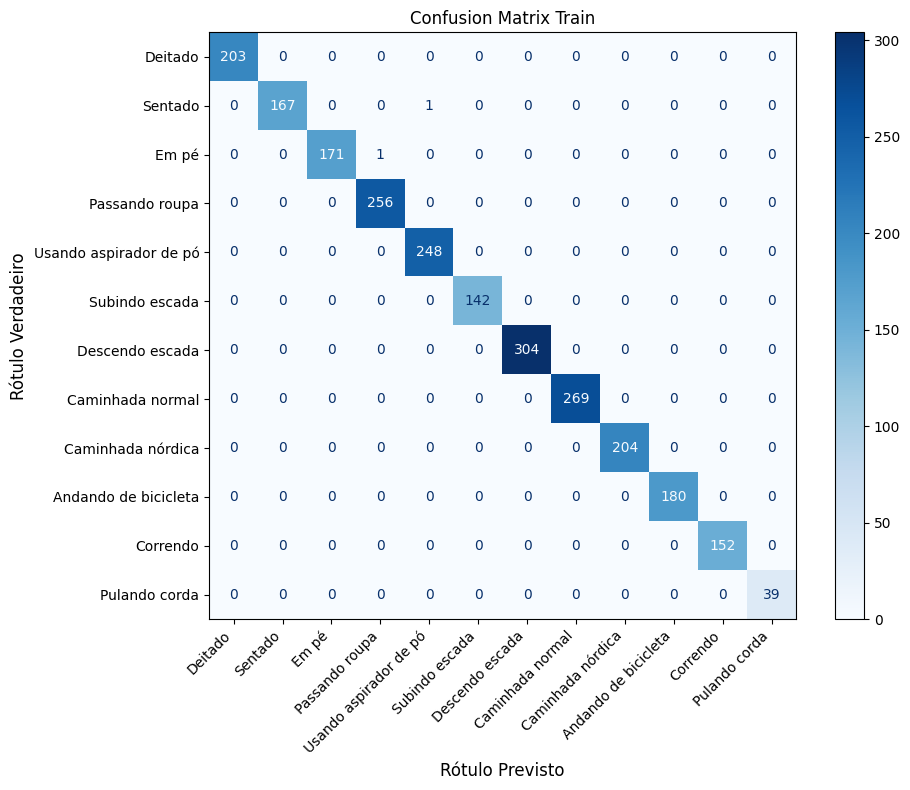


			 WeightedEnsemble_L3

						TRAIN REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       203
         2.0       1.00      0.99      1.00       168
         3.0       1.00      1.00      1.00       172
         4.0       1.00      1.00      1.00       269
         5.0       1.00      1.00      1.00       152
         6.0       1.00      1.00      1.00       180
         7.0       1.00      1.00      1.00       204
        12.0       1.00      1.00      1.00       142
        13.0       1.00      1.00      1.00       304
        16.0       1.00      1.00      1.00       248
        17.0       1.00      1.00      1.00       256
        24.0       1.00      1.00      1.00        39

    accuracy                           1.00      2337
   macro avg       1.00      1.00      1.00      2337
weighted avg       1.00      1.00      1.00      2337




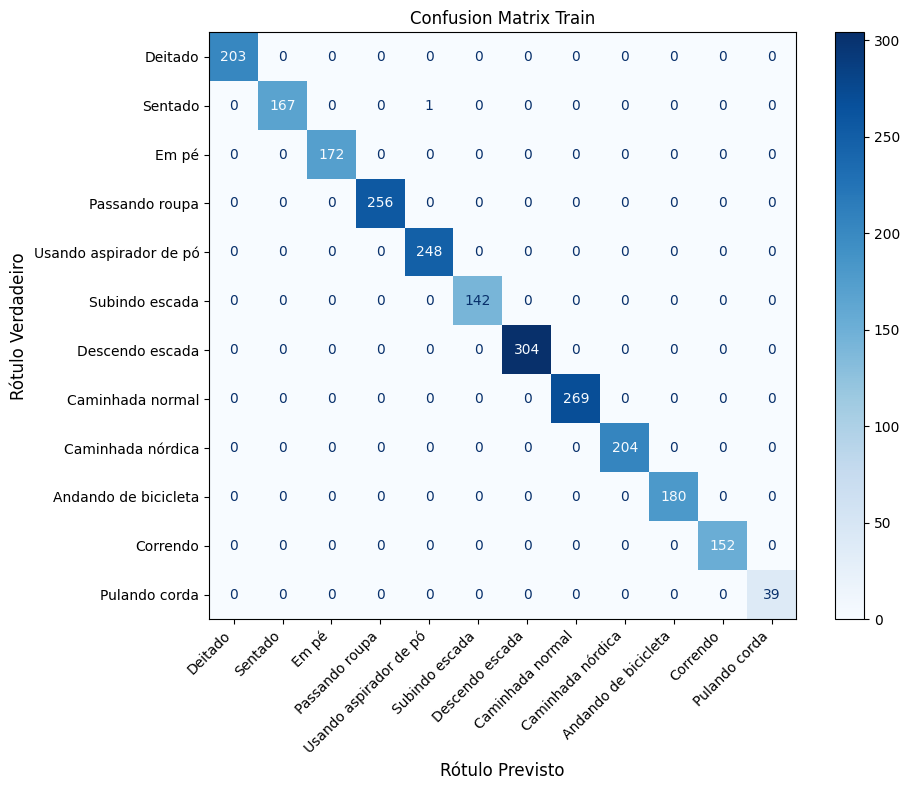


			 ExtraTreesGini_BAG_L2

						TRAIN REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       203
         2.0       1.00      0.98      0.99       168
         3.0       0.99      1.00      0.99       172
         4.0       1.00      1.00      1.00       269
         5.0       1.00      1.00      1.00       152
         6.0       1.00      1.00      1.00       180
         7.0       1.00      1.00      1.00       204
        12.0       1.00      1.00      1.00       142
        13.0       1.00      1.00      1.00       304
        16.0       1.00      1.00      1.00       248
        17.0       1.00      1.00      1.00       256
        24.0       1.00      0.97      0.99        39

    accuracy                           1.00      2337
   macro avg       1.00      1.00      1.00      2337
weighted avg       1.00      1.00      1.00      2337




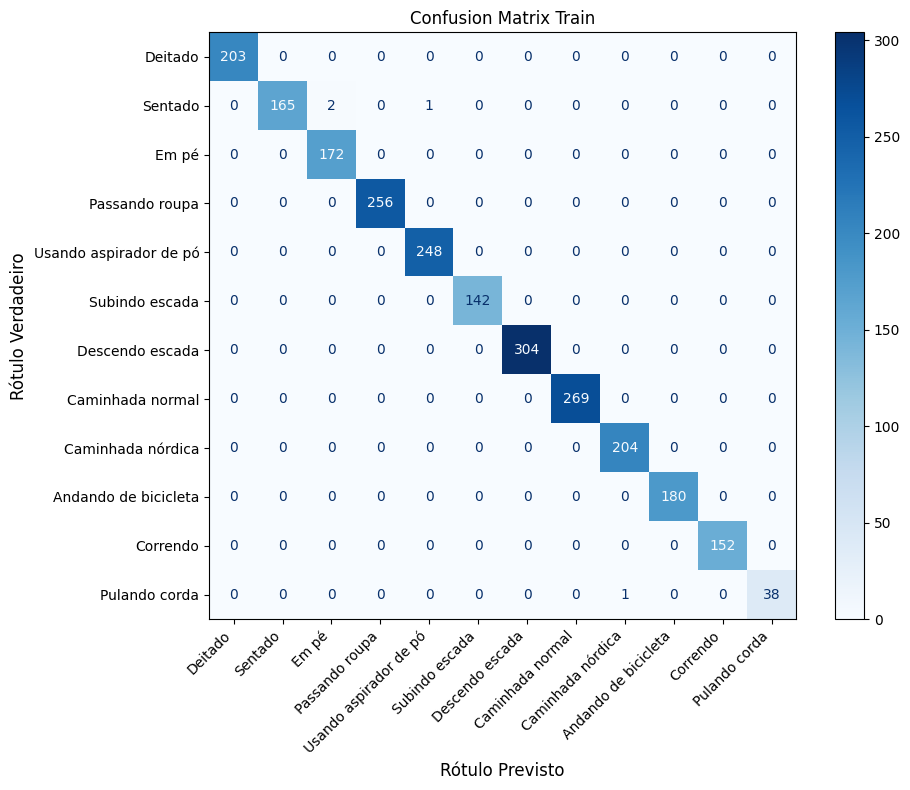


			 ExtraTreesEntr_BAG_L2

						TRAIN REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       203
         2.0       1.00      0.98      0.99       168
         3.0       0.99      0.99      0.99       172
         4.0       1.00      1.00      1.00       269
         5.0       1.00      1.00      1.00       152
         6.0       1.00      1.00      1.00       180
         7.0       1.00      1.00      1.00       204
        12.0       1.00      1.00      1.00       142
        13.0       1.00      1.00      1.00       304
        16.0       1.00      1.00      1.00       248
        17.0       1.00      1.00      1.00       256
        24.0       1.00      0.97      0.99        39

    accuracy                           1.00      2337
   macro avg       1.00      1.00      1.00      2337
weighted avg       1.00      1.00      1.00      2337




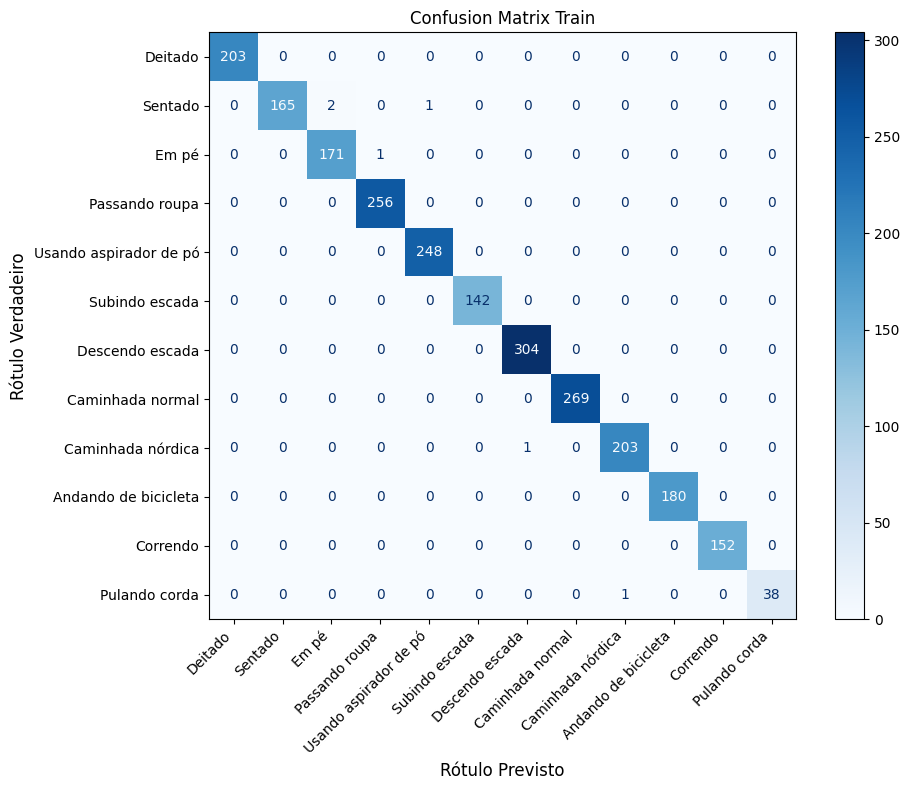


			 ExtraTreesGini_BAG_L1

						TRAIN REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       203
         2.0       1.00      1.00      1.00       168
         3.0       1.00      1.00      1.00       172
         4.0       1.00      1.00      1.00       269
         5.0       1.00      1.00      1.00       152
         6.0       1.00      1.00      1.00       180
         7.0       1.00      1.00      1.00       204
        12.0       1.00      1.00      1.00       142
        13.0       1.00      1.00      1.00       304
        16.0       1.00      1.00      1.00       248
        17.0       1.00      1.00      1.00       256
        24.0       1.00      1.00      1.00        39

    accuracy                           1.00      2337
   macro avg       1.00      1.00      1.00      2337
weighted avg       1.00      1.00      1.00      2337




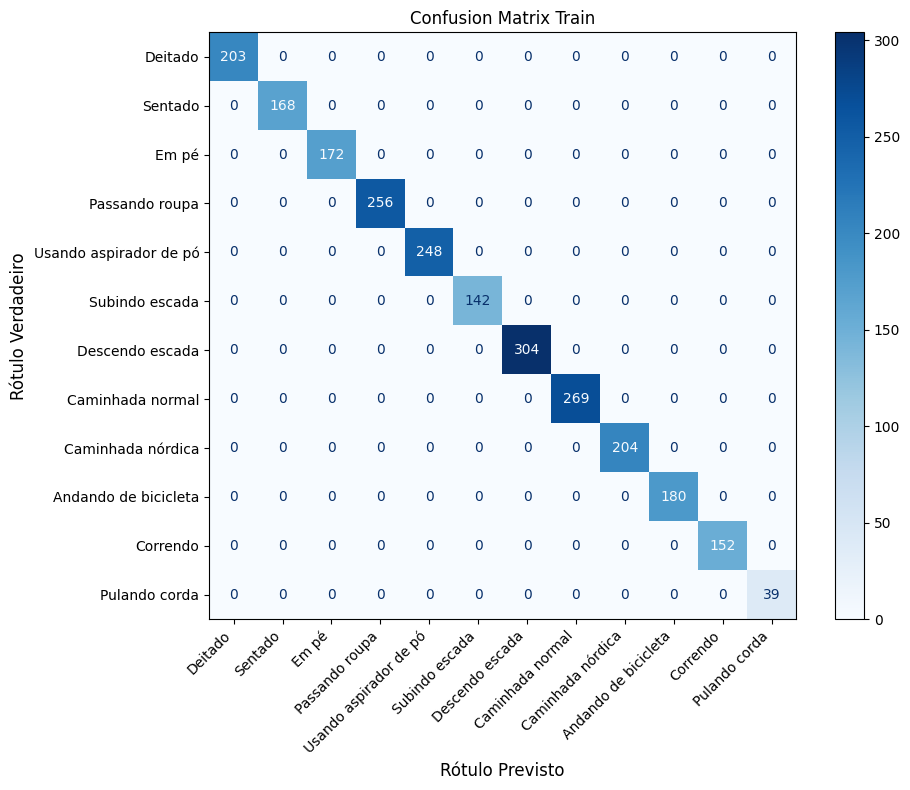

In [ ]:
show_results(detailed_results_train_tsfresh, list(train_tsfresh['activityID'].unique()))


						TEST REPORT

              precision    recall  f1-score   support

         1.0       0.72      1.00      0.84        31
         2.0       0.65      1.00      0.79        11
         3.0       0.96      1.00      0.98        25
         4.0       0.97      0.78      0.86        41
         5.0       1.00      0.67      0.80         3
         6.0       1.00      0.79      0.88        28
         7.0       0.74      0.85      0.79        33
        12.0       1.00      0.71      0.83        21
        13.0       0.94      0.94      0.94        34
        16.0       1.00      0.58      0.73        31
        17.0       0.78      1.00      0.88        35

    accuracy                           0.86       293
   macro avg       0.89      0.85      0.85       293
weighted avg       0.89      0.86      0.86       293




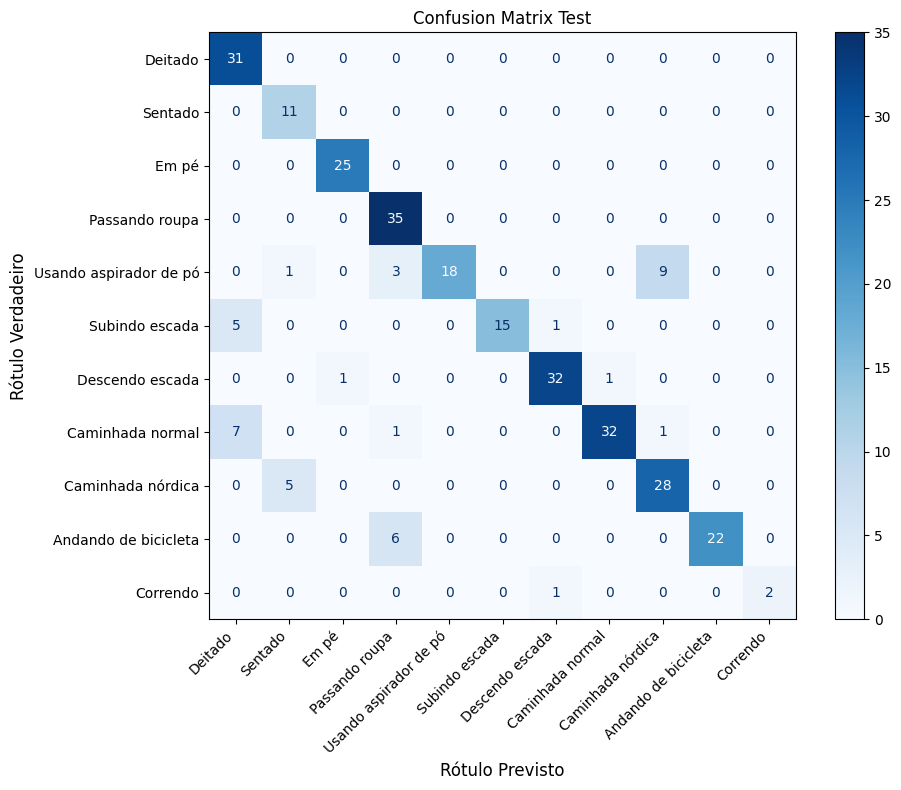


						TEST REPORT

              precision    recall  f1-score   support

         1.0       0.91      1.00      0.95        31
         2.0       0.52      1.00      0.69        11
         3.0       0.50      1.00      0.67        25
         4.0       0.89      0.98      0.93        41
         5.0       1.00      1.00      1.00         3
         6.0       1.00      1.00      1.00        28
         7.0       1.00      1.00      1.00        33
        12.0       1.00      0.76      0.86        21
        13.0       1.00      0.32      0.49        34
        16.0       1.00      0.55      0.71        31
        17.0       0.91      0.91      0.91        35

    accuracy                           0.84       293
   macro avg       0.89      0.87      0.84       293
weighted avg       0.90      0.84      0.84       293




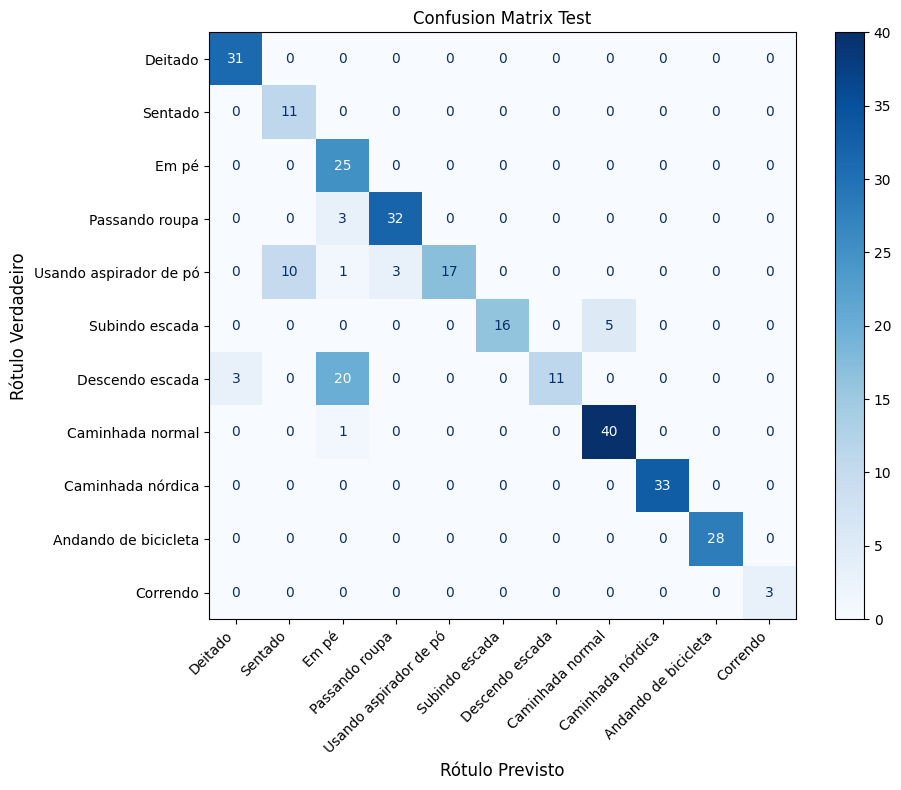


						TEST REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        31
         2.0       0.46      1.00      0.63        11
         3.0       0.44      0.96      0.60        25
         4.0       0.87      0.80      0.84        41
         5.0       1.00      1.00      1.00         3
         6.0       1.00      1.00      1.00        28
         7.0       1.00      1.00      1.00        33
        12.0       1.00      0.76      0.86        21
        13.0       1.00      0.32      0.49        34
        16.0       1.00      0.58      0.73        31
        17.0       0.92      0.94      0.93        35

    accuracy                           0.82       293
   macro avg       0.88      0.85      0.83       293
weighted avg       0.90      0.82      0.82       293




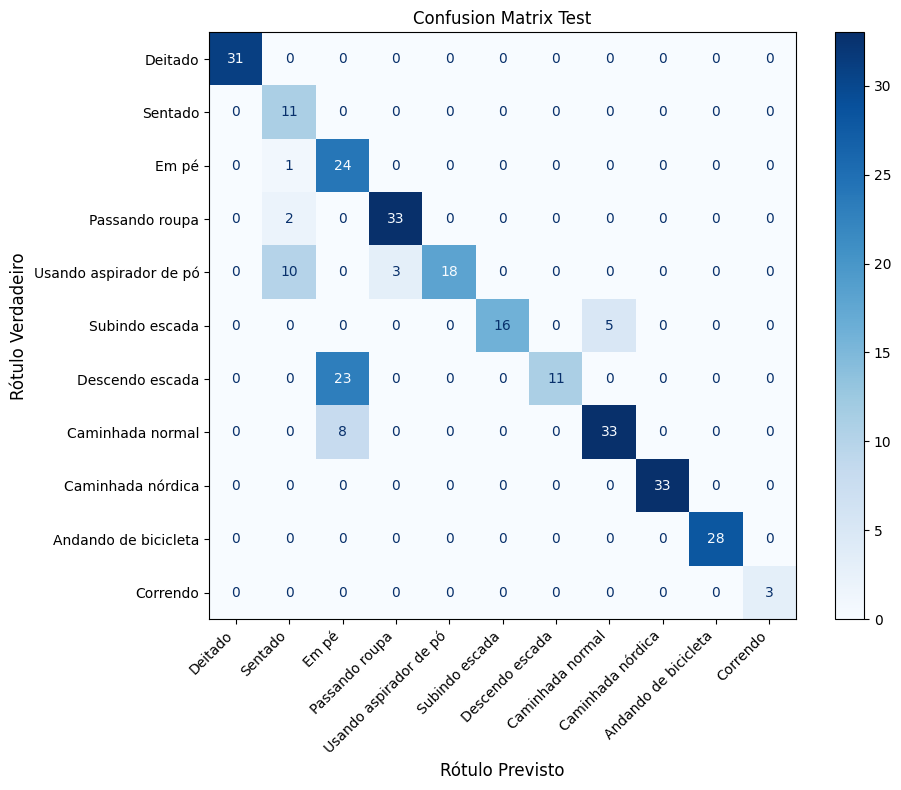


						TEST REPORT

              precision    recall  f1-score   support

         1.0       0.91      1.00      0.95        31
         2.0       0.52      1.00      0.69        11
         3.0       0.47      1.00      0.64        25
         4.0       0.85      0.80      0.83        41
         5.0       1.00      1.00      1.00         3
         6.0       1.00      1.00      1.00        28
         7.0       1.00      1.00      1.00        33
        12.0       1.00      0.76      0.86        21
        13.0       1.00      0.29      0.45        34
        16.0       1.00      0.58      0.73        31
        17.0       0.92      1.00      0.96        35

    accuracy                           0.83       293
   macro avg       0.88      0.86      0.83       293
weighted avg       0.90      0.83      0.82       293




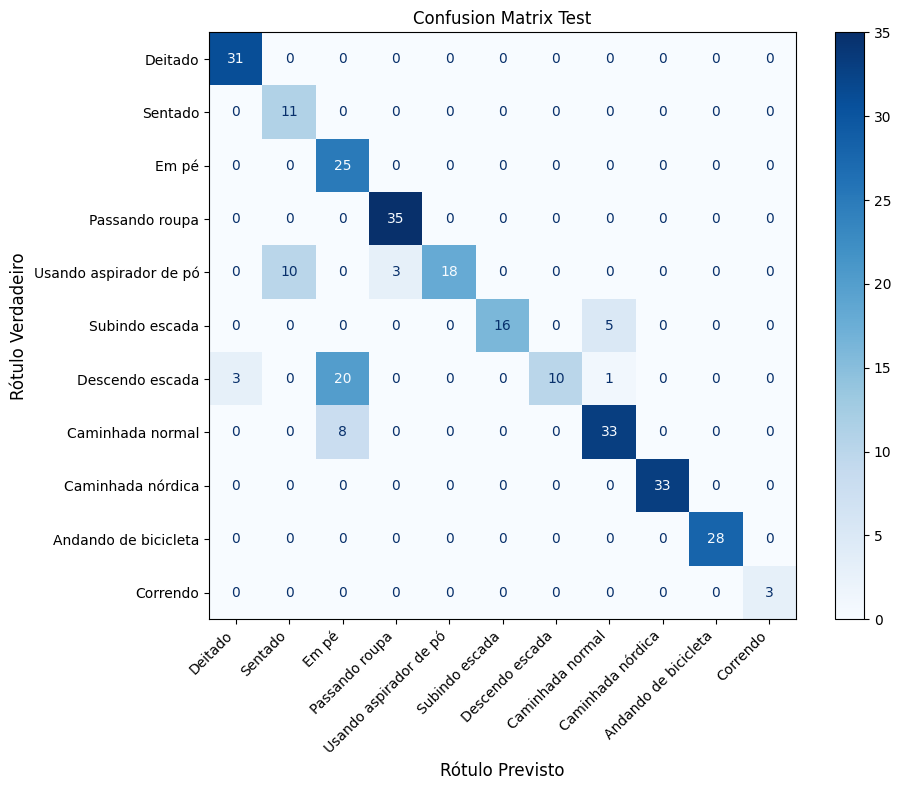


						TEST REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        31
         2.0       1.00      1.00      1.00        11
         3.0       0.54      1.00      0.70        25
         4.0       0.82      1.00      0.90        41
         5.0       1.00      1.00      1.00         3
         6.0       0.85      1.00      0.92        28
         7.0       0.74      0.85      0.79        33
        12.0       1.00      0.76      0.86        21
        13.0       1.00      0.29      0.45        34
        16.0       1.00      0.58      0.73        31
        17.0       0.92      0.97      0.94        35

    accuracy                           0.84       293
   macro avg       0.90      0.86      0.85       293
weighted avg       0.88      0.84      0.82       293




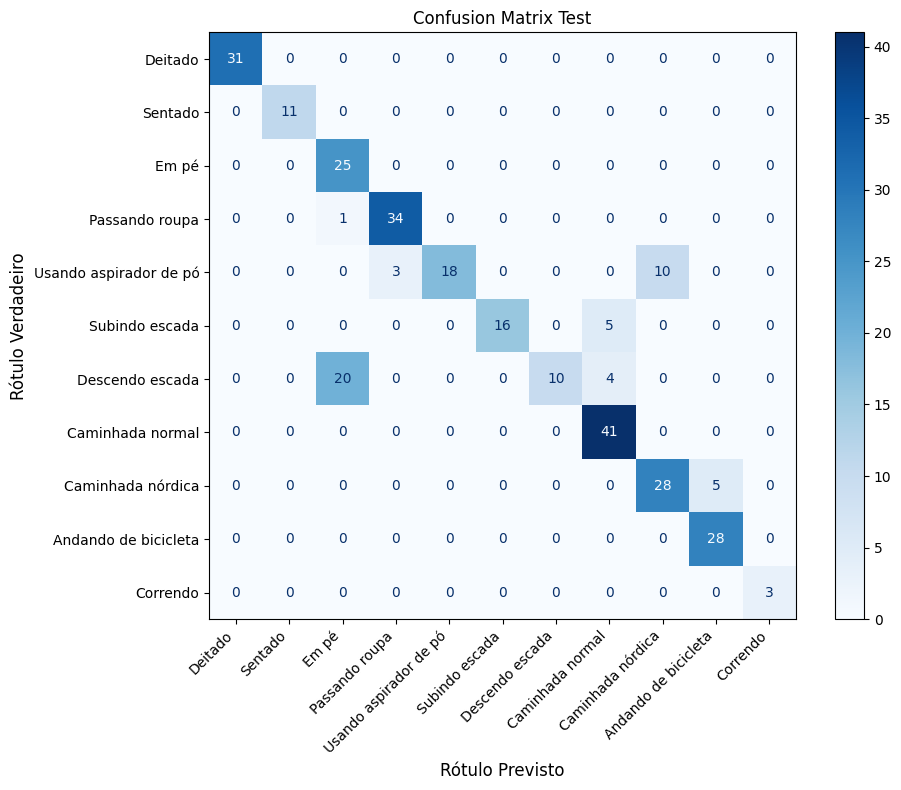

In [ ]:
test_report_latex_tsfresh = show_results(detailed_results_test_tsfresh, list(test_tsfresh['activityID'].unique()), train=False)


			 WeightedEnsemble_L3

						TRAIN REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       203
         2.0       1.00      1.00      1.00       168
         3.0       1.00      1.00      1.00       172
         4.0       1.00      1.00      1.00       269
         5.0       1.00      1.00      1.00       152
         6.0       1.00      1.00      1.00       180
         7.0       1.00      1.00      1.00       204
        12.0       1.00      1.00      1.00       142
        13.0       1.00      1.00      1.00       304
        16.0       1.00      1.00      1.00       248
        17.0       1.00      1.00      1.00       256
        24.0       1.00      1.00      1.00        39

    accuracy                           1.00      2337
   macro avg       1.00      1.00      1.00      2337
weighted avg       1.00      1.00      1.00      2337




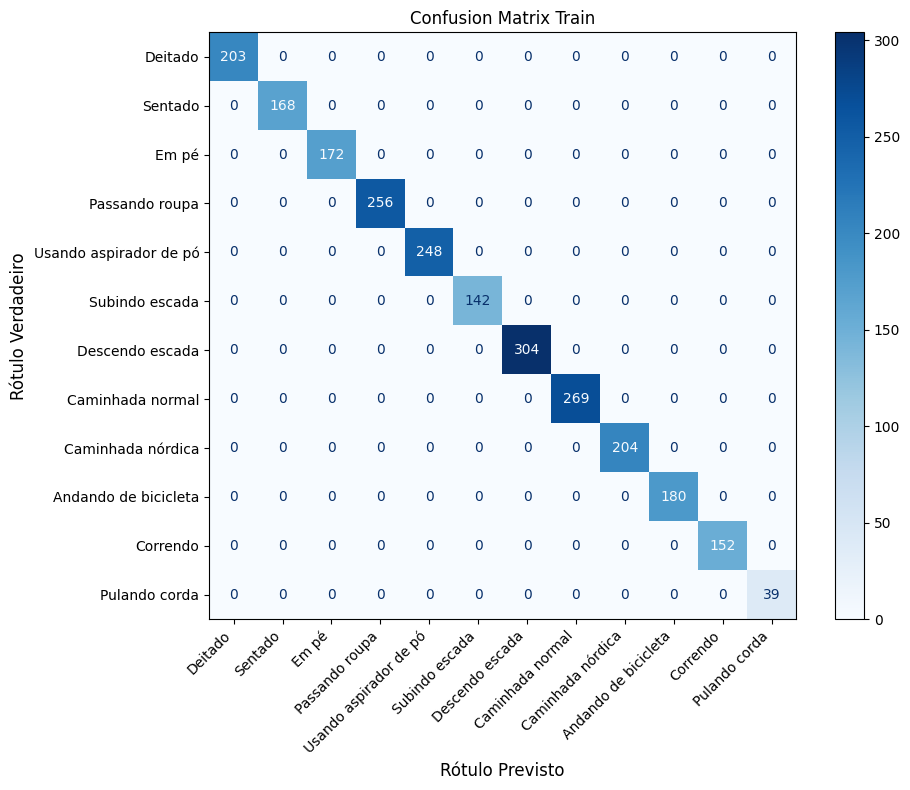


			 WeightedEnsemble_L2

						TRAIN REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       203
         2.0       1.00      1.00      1.00       168
         3.0       1.00      1.00      1.00       172
         4.0       1.00      1.00      1.00       269
         5.0       1.00      1.00      1.00       152
         6.0       1.00      1.00      1.00       180
         7.0       1.00      1.00      1.00       204
        12.0       1.00      1.00      1.00       142
        13.0       1.00      1.00      1.00       304
        16.0       1.00      1.00      1.00       248
        17.0       1.00      1.00      1.00       256
        24.0       1.00      1.00      1.00        39

    accuracy                           1.00      2337
   macro avg       1.00      1.00      1.00      2337
weighted avg       1.00      1.00      1.00      2337




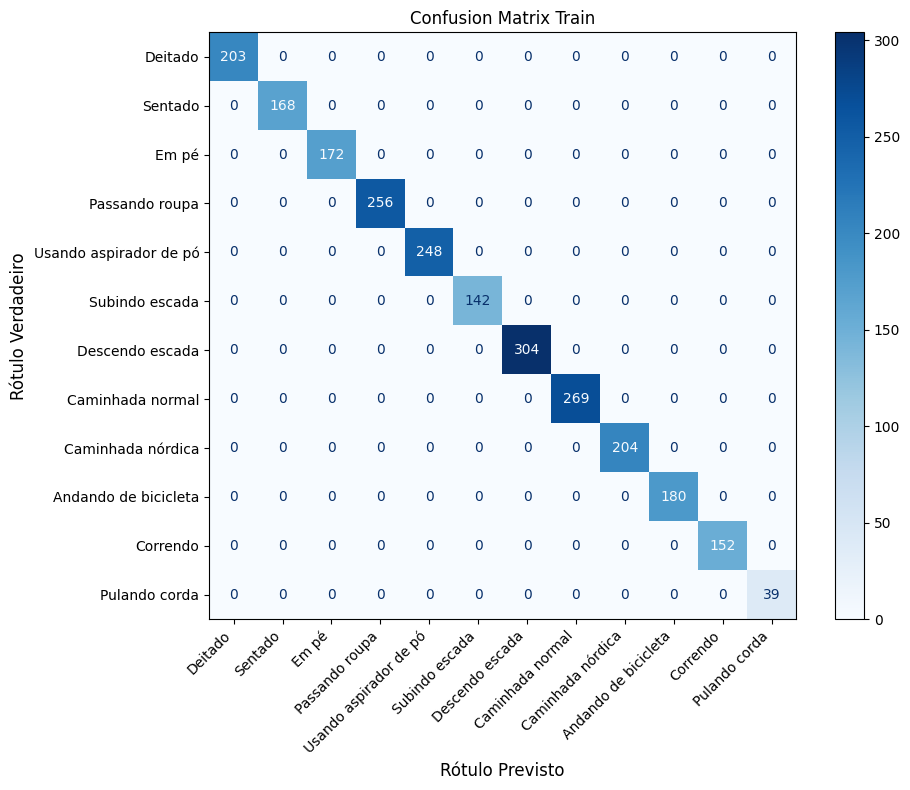


			 ExtraTreesEntr_BAG_L2

						TRAIN REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       203
         2.0       1.00      1.00      1.00       168
         3.0       1.00      1.00      1.00       172
         4.0       1.00      1.00      1.00       269
         5.0       1.00      1.00      1.00       152
         6.0       1.00      1.00      1.00       180
         7.0       1.00      1.00      1.00       204
        12.0       1.00      1.00      1.00       142
        13.0       1.00      1.00      1.00       304
        16.0       1.00      1.00      1.00       248
        17.0       1.00      1.00      1.00       256
        24.0       1.00      1.00      1.00        39

    accuracy                           1.00      2337
   macro avg       1.00      1.00      1.00      2337
weighted avg       1.00      1.00      1.00      2337




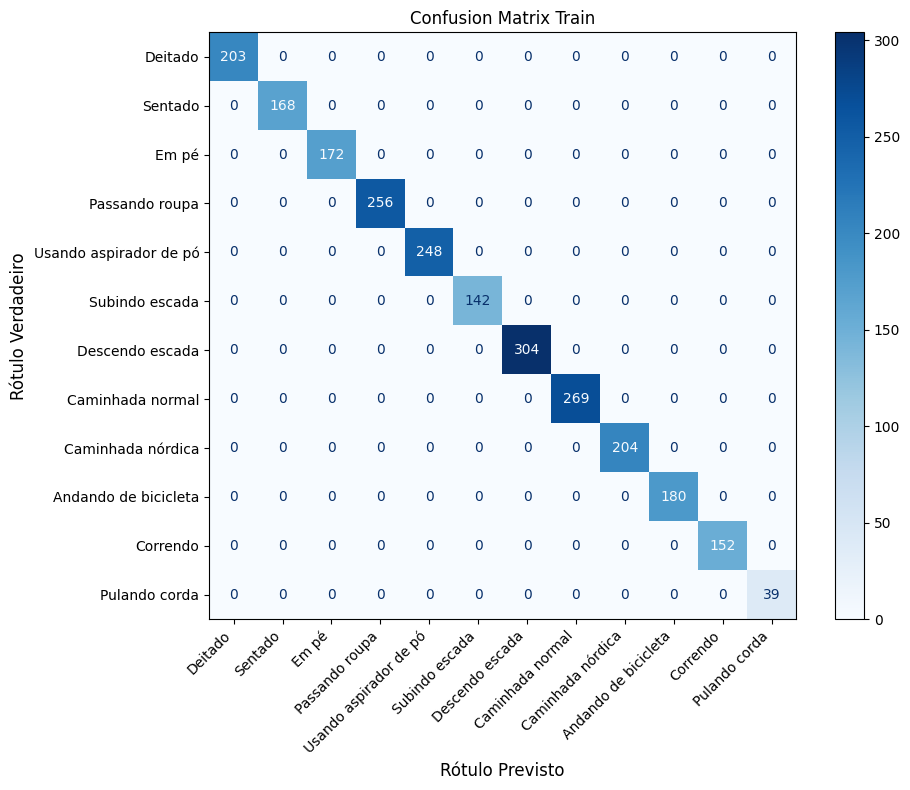


			 ExtraTrees_r49_BAG_L2

						TRAIN REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       203
         2.0       1.00      1.00      1.00       168
         3.0       1.00      1.00      1.00       172
         4.0       1.00      1.00      1.00       269
         5.0       1.00      1.00      1.00       152
         6.0       1.00      1.00      1.00       180
         7.0       1.00      1.00      1.00       204
        12.0       1.00      1.00      1.00       142
        13.0       1.00      1.00      1.00       304
        16.0       1.00      1.00      1.00       248
        17.0       1.00      1.00      1.00       256
        24.0       1.00      1.00      1.00        39

    accuracy                           1.00      2337
   macro avg       1.00      1.00      1.00      2337
weighted avg       1.00      1.00      1.00      2337




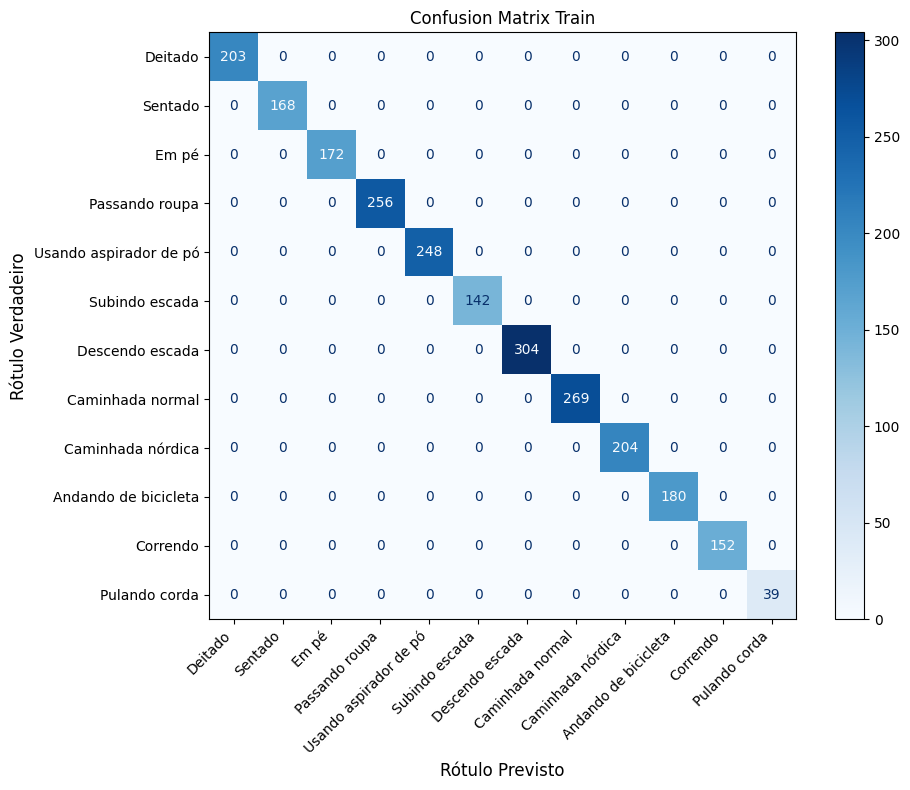


			 RandomForest_r166_BAG_L2

						TRAIN REPORT

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       203
         2.0       1.00      1.00      1.00       168
         3.0       1.00      1.00      1.00       172
         4.0       1.00      1.00      1.00       269
         5.0       1.00      1.00      1.00       152
         6.0       1.00      1.00      1.00       180
         7.0       1.00      1.00      1.00       204
        12.0       1.00      1.00      1.00       142
        13.0       1.00      1.00      1.00       304
        16.0       1.00      1.00      1.00       248
        17.0       1.00      1.00      1.00       256
        24.0       1.00      1.00      1.00        39

    accuracy                           1.00      2337
   macro avg       1.00      1.00      1.00      2337
weighted avg       1.00      1.00      1.00      2337




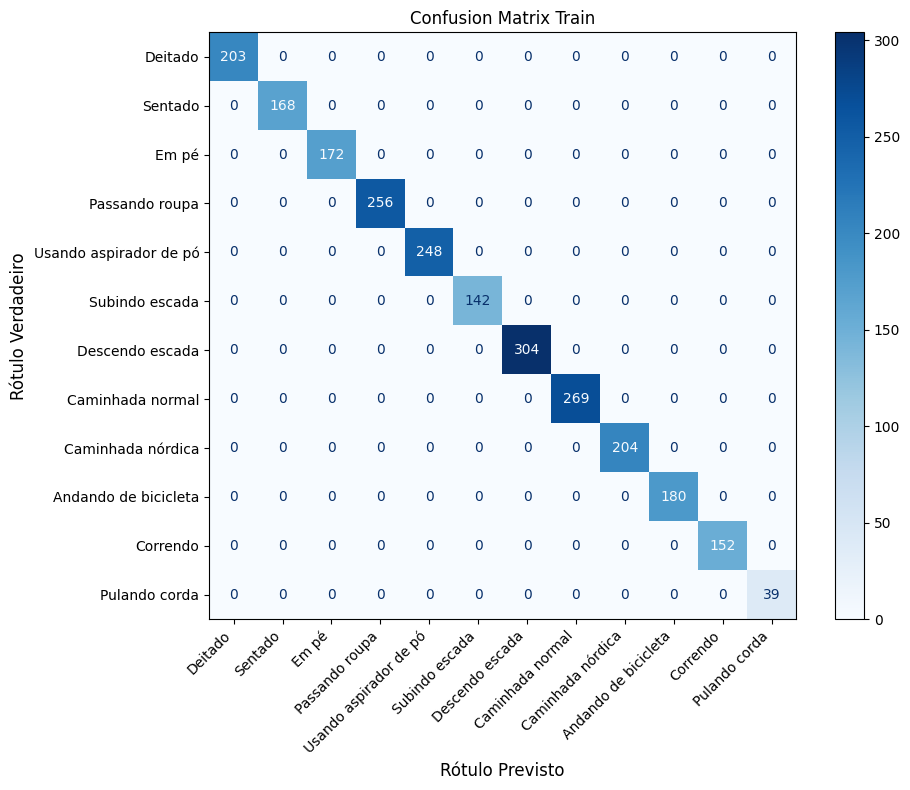

In [ ]:
train_report_latex_catch22 = show_results(detailed_results_train_catch22, list(train_catch22['activityID'].unique()))


						TEST REPORT

              precision    recall  f1-score   support

         1.0       0.81      0.94      0.87        31
         2.0       0.73      1.00      0.85        11
         3.0       0.88      0.84      0.86        25
         4.0       1.00      0.78      0.88        41
         5.0       1.00      1.00      1.00         3
         6.0       1.00      0.89      0.94        28
         7.0       1.00      1.00      1.00        33
        12.0       1.00      1.00      1.00        21
        13.0       0.89      1.00      0.94        34
        16.0       0.93      0.87      0.90        31
        17.0       0.86      0.91      0.89        35

    accuracy                           0.91       293
   macro avg       0.92      0.93      0.92       293
weighted avg       0.92      0.91      0.91       293




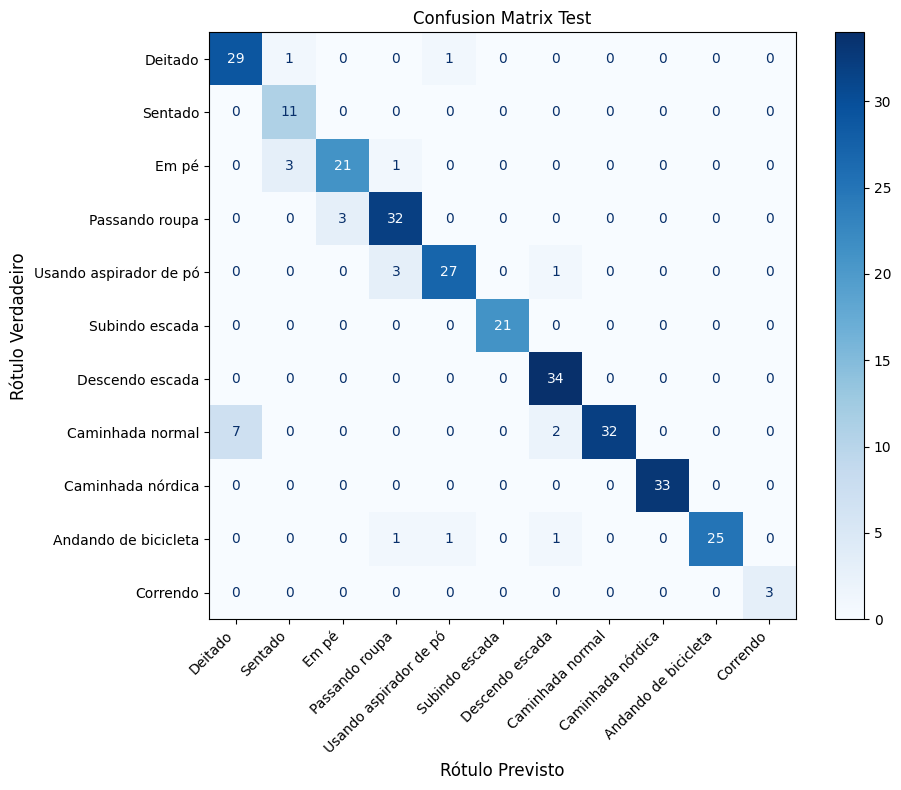


						TEST REPORT

              precision    recall  f1-score   support

         1.0       0.81      0.94      0.87        31
         2.0       0.65      1.00      0.79        11
         3.0       0.86      0.76      0.81        25
         4.0       1.00      0.80      0.89        41
         5.0       1.00      1.00      1.00         3
         6.0       1.00      0.89      0.94        28
         7.0       1.00      1.00      1.00        33
        12.0       0.88      1.00      0.93        21
        13.0       0.91      0.91      0.91        34
        16.0       0.93      0.90      0.92        31
        17.0       0.89      0.91      0.90        35

    accuracy                           0.90       293
   macro avg       0.90      0.92      0.91       293
weighted avg       0.92      0.90      0.91       293




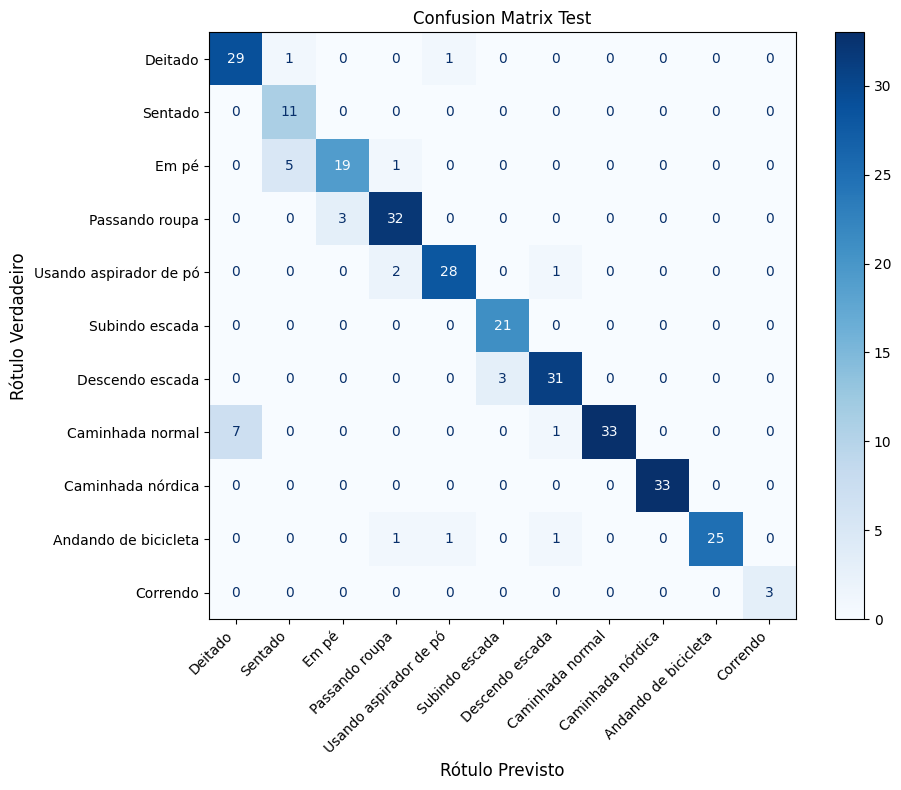


						TEST REPORT

              precision    recall  f1-score   support

         1.0       0.79      0.97      0.87        31
         2.0       0.65      1.00      0.79        11
         3.0       0.90      0.76      0.83        25
         4.0       1.00      0.80      0.89        41
         5.0       0.38      1.00      0.55         3
         6.0       1.00      0.89      0.94        28
         7.0       1.00      1.00      1.00        33
        12.0       0.84      0.76      0.80        21
        13.0       0.94      0.91      0.93        34
        16.0       0.93      0.90      0.92        31
        17.0       0.92      0.94      0.93        35

    accuracy                           0.89       293
   macro avg       0.85      0.90      0.86       293
weighted avg       0.91      0.89      0.90       293




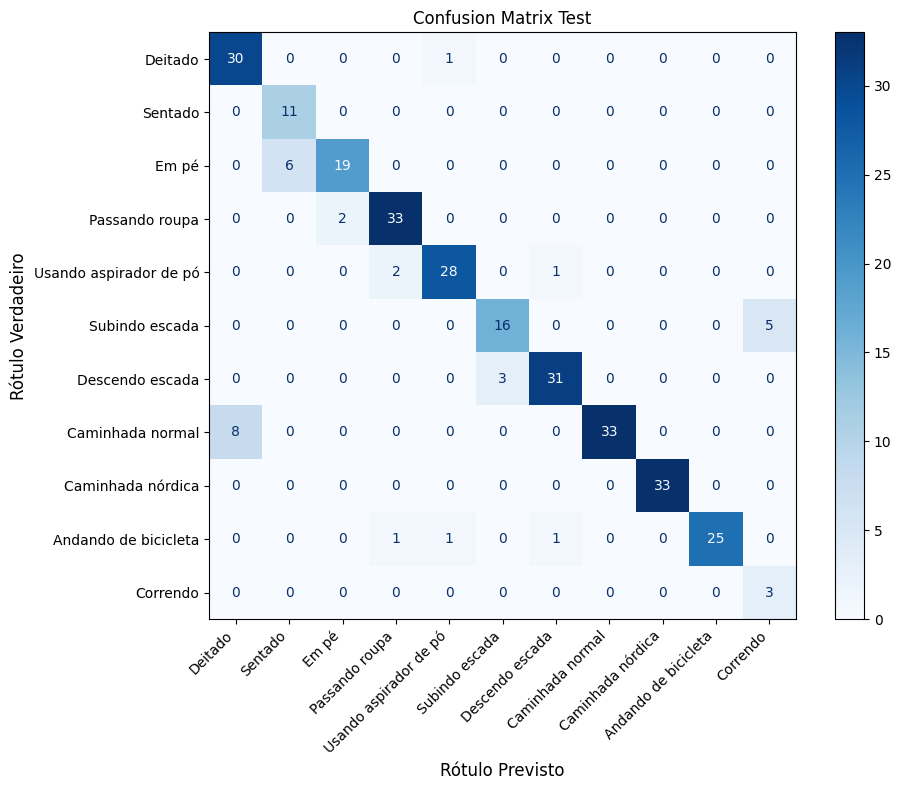


						TEST REPORT

              precision    recall  f1-score   support

         1.0       0.79      0.97      0.87        31
         2.0       0.65      1.00      0.79        11
         3.0       0.90      0.76      0.83        25
         4.0       1.00      0.80      0.89        41
         5.0       0.38      1.00      0.55         3
         6.0       1.00      0.89      0.94        28
         7.0       1.00      1.00      1.00        33
        12.0       0.84      0.76      0.80        21
        13.0       0.94      0.91      0.93        34
        16.0       0.93      0.90      0.92        31
        17.0       0.92      0.94      0.93        35

    accuracy                           0.89       293
   macro avg       0.85      0.90      0.86       293
weighted avg       0.91      0.89      0.90       293




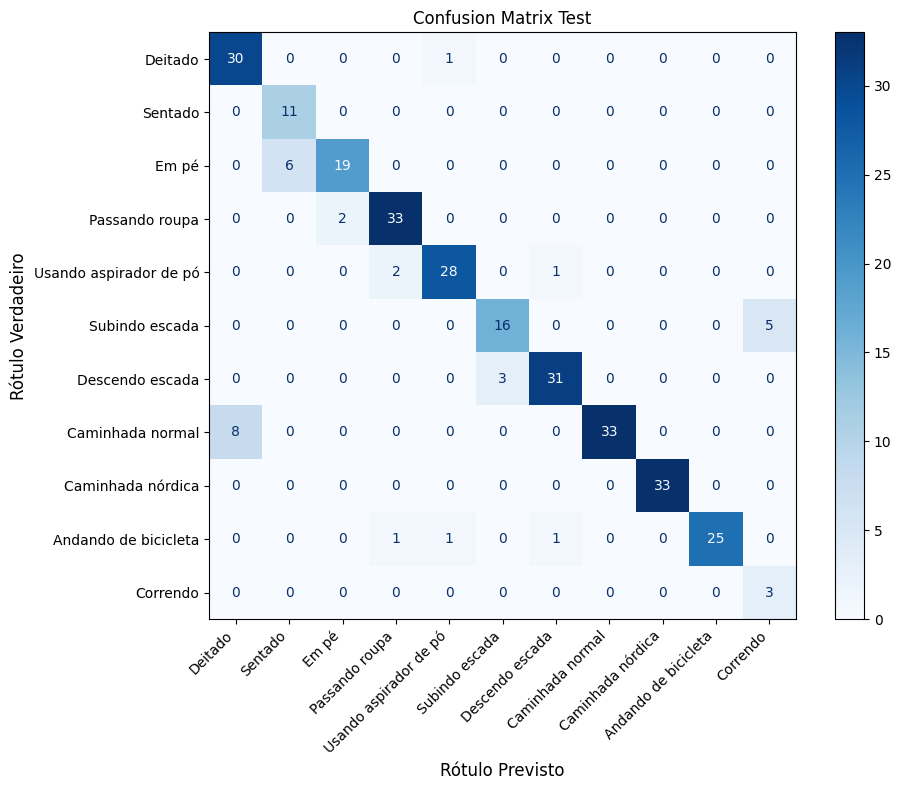


						TEST REPORT

              precision    recall  f1-score   support

         1.0       0.78      0.94      0.85        31
         2.0       0.65      1.00      0.79        11
         3.0       0.91      0.80      0.85        25
         4.0       1.00      0.80      0.89        41
         5.0       1.00      1.00      1.00         3
         6.0       1.00      0.89      0.94        28
         7.0       1.00      1.00      1.00        33
        12.0       1.00      1.00      1.00        21
        13.0       0.94      1.00      0.97        34
        16.0       0.90      0.58      0.71        31
        17.0       0.72      0.94      0.81        35

    accuracy                           0.89       293
   macro avg       0.90      0.91      0.89       293
weighted avg       0.91      0.89      0.89       293




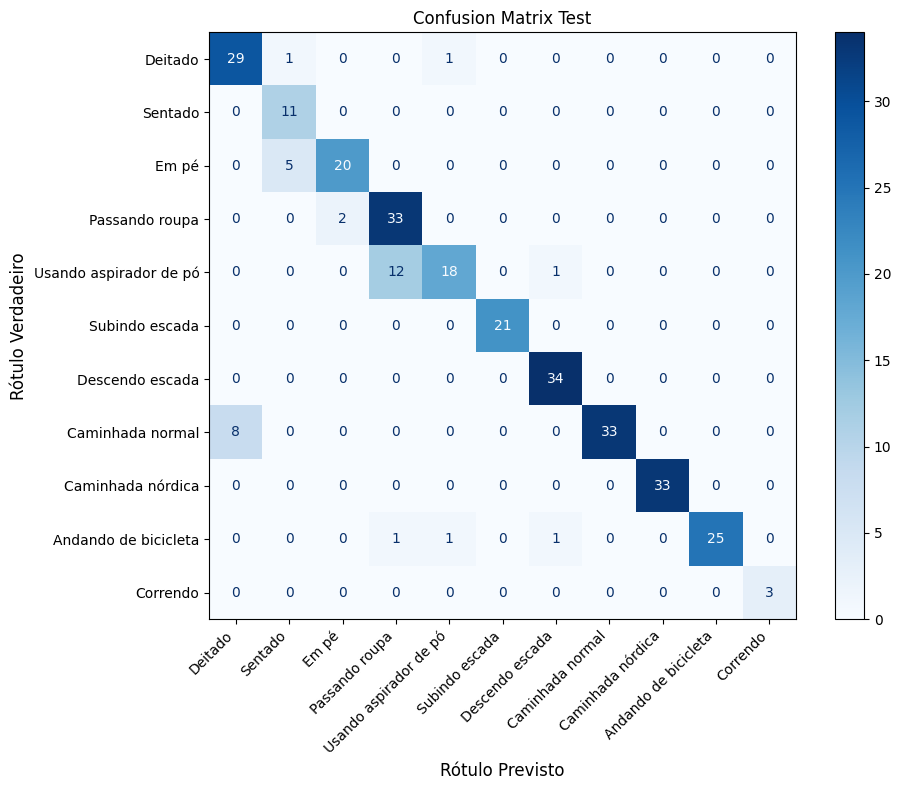

In [ ]:
test_report_latex_catch22 = show_results(detailed_results_test_catch22, list(test_catch22['activityID'].unique()), train=False)